# Projet - Système de classification d'images par apprendissage profond
http://gbgi9u07.imag.fr/doku.php?id=projet

We will do the following steps in order:
1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# jeu d'entrainement
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Charge les images
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# jeu de vérification
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Test de reconnaissance

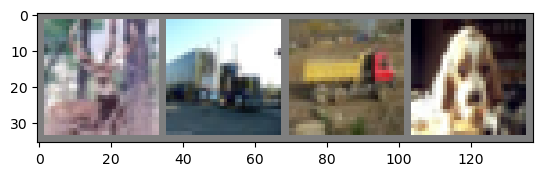

deer  truck truck dog  


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network

In [3]:
# Copy the neural network from the Neural Networks section before and 
# modify it to take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # Listage des couches / sous-couches
    #3*32*32
    #Conv
    #6*28*28
    #Relu
    #Pooling
    #6*14*14
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Dans la partie entraînement du réseau CNN, lister les différentes couches et sous-couches.
Donner la taille des différents tenseurs de données Xn et de poids Wn le long du calcul.
Modifier le programme pour faire l'évaluation après chaque époque et aussi avant la première (faire une fonction spécialisée). Supprimer les autres affichages intermédiaires.
Modifier les fonctions pour calculer à chaque étape le nombre d'opérations flottantes effectuées, séparément pour les additions, les multiplications, les maximums et le total.
Afficher en fin de passe, en plus du taux d'erreur global, le nombre d'opérations effectuées, le temps d'exécution, et le nombre d'opérations par seconde.

In [5]:
from torchsummary import summary

# Nb total de parametres
print(f"NB TOTAL PARAMETERS : {sum(p.numel() for p in net.parameters())}")

#Taille des tensors  
for p in net.parameters():
    print(p.shape) #Poids Xn et Wn 

#Network Summary
print("-------SUMMARY-------")
summary(net, (3, 32, 32))


NB TOTAL PARAMETERS : 62006
torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])
-------SUMMARY-------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           456
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Conv2d: 1-3                            [-1, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [-1, 16, 5, 5]            --
├─Linear: 1-5                            [-1, 120]                 48,120
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 10]                  850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 0.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (M

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           456
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Conv2d: 1-3                            [-1, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [-1, 16, 5, 5]            --
├─Linear: 1-5                            [-1, 120]                 48,120
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 10]                  850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 0.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

### 3. Define a Loss function and optimizer
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer

In [1]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

ModuleNotFoundError: No module named 'torch'

### 4. Train the network
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network

In [6]:
PATH = './cifar_net.pth'

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

print('Finished Training')

KeyboardInterrupt: 

### 5. Test the network on the test data
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#test-the-network-on-the-test-data

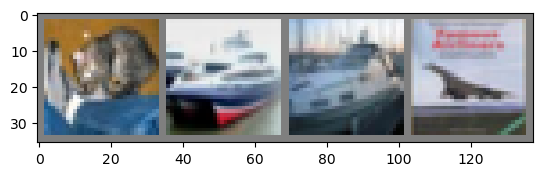

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
#Loading previous results
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

#Prédictions
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [ ]:
#Accuracy of the network
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.7 %
Accuracy for class: car   is 66.5 %
Accuracy for class: bird  is 41.1 %
Accuracy for class: cat   is 43.2 %
Accuracy for class: deer  is 38.5 %
Accuracy for class: dog   is 37.6 %
Accuracy for class: frog  is 70.4 %
Accuracy for class: horse is 61.1 %
Accuracy for class: ship  is 76.6 %
Accuracy for class: truck is 68.0 %
